In [84]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf


In [85]:
# 1. Import data
# Close prices + Other prices + Volumes
file_path = './data/SMCI_merged.csv'
data = pd.read_csv(file_path)

In [86]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

columns_to_keep = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'DPRIME', 'VIX_Close']
data = data[columns_to_keep]

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [87]:
# # Split data, method 1
# total_length = len(data)
# train_length = int(total_length * 0.80)
# train_set = data.iloc[:train_length].copy()
# valid_set = data.iloc[train_length:].copy()

# Split data, method 2
train_set = data[(data.index >= '2014-06-24') & (data.index < '2023-06-24')].copy()
valid_set = data[(data.index >= '2022-06-25') & (data.index <= '2024-06-21')].copy()


In [88]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 90     # tested [30, 60, 90, 120], 90 is the most efficient one

# 2.3 Feature selection
all_features = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'DPRIME', 'VIX_Close']
# selected_features = ['Close/Last', 'Volume']
selected_features = ['Close/Last']
num_features = len(selected_features)

In [89]:
# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close/Last' column for both training and validation sets
train_data = scaler.fit_transform(train_set[selected_features].values)
valid_data = scaler.transform(valid_set[selected_features].values)

# Initialize lists to store training and validation data
# x may contain multiple features, while y is the target value that is being predicted, the close price
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :])
    y_train.append(train_data[i, 0])  # Only keep the Close/Last column as label

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[i-time_steps:i, :])
    y_valid.append(valid_data[i, 0])  # Only keep the Close/Last column as label


# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(selected_features)))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], len(selected_features)))

In [90]:
# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [93]:
# Training
model = build_model()
model.fit(x_train, y_train, epochs=25, batch_size=32)

# Make Prediction
predicted_y_valid_normalized = model.predict(x_valid)
predicted_y_valid = scaler.inverse_transform(predicted_y_valid_normalized)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0458
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0036
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0030
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0028
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0026
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0028
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0023
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0026
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0025
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0026
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0023
Epoch 13/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0021
Epoch 14/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0020
Epoch 15/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0020
Epoch 16/25
61/

LSTM RMSE on validation set: 315.6721001658489


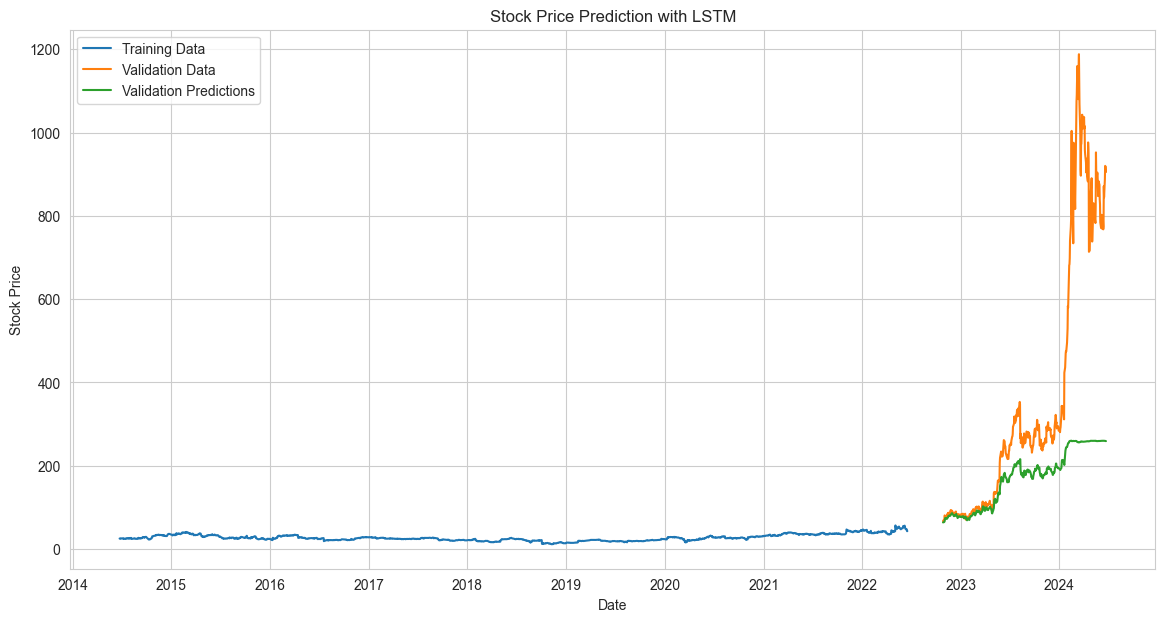

In [94]:
# Print & Visualize the results
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(train_set.index, train_set['Close/Last'], label='Training Data')
plt.plot(valid_set.index[time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set.index[time_steps:], predicted_y_valid, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()